# Элементарные методы анализа временных рядов

### Задание:
- Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
- Приблизьте оба варианта моделями из класса MA.
- Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [4]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [5]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

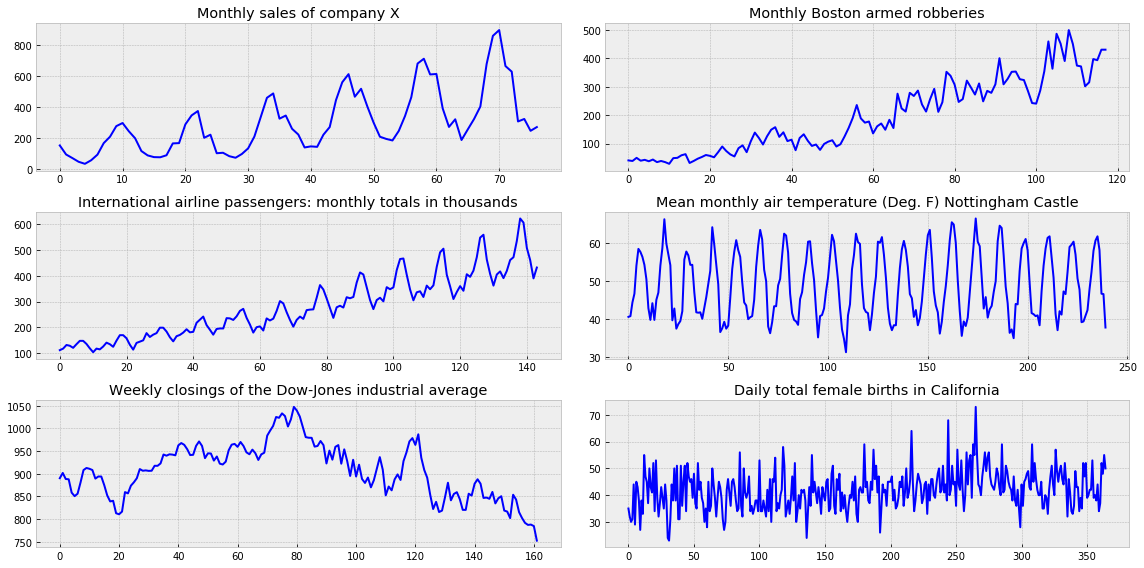

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [19]:
# Функция для подсчета скользяшего среднего
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

# Функция для подсчета взвешенного скользяшего среднего
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

# Функция для подсчета экспоненциального скользяшего среднего
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

# Функция для подсчета двойного экспоненциального скользяшего среднего
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

# Функция для подсчета тройного экспоненциального скользяшего среднего
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [22]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [23]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

## Анализ временного ряда female_births

In [53]:
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [54]:
series = female_births["Count"]

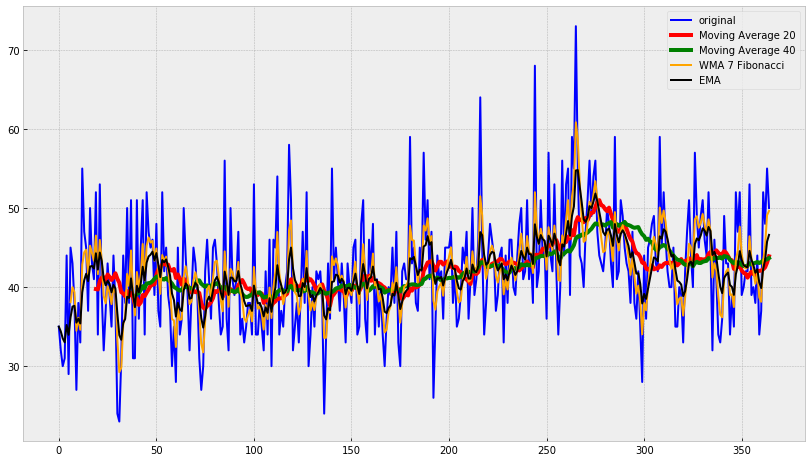

In [76]:
# Применим разные скользящие средние и визуализируем

ma20 = moving_average(series, 20)
ma40 = moving_average(series, 40)

wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])

ema = exponential_moving_average(series, 0.2)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma20, color='red', linewidth='4', label='Moving Average 20')
    plt.plot(ma40, color='green', linewidth='4', label='Moving Average 40')
    plt.plot(wma_fib, color='orange', linewidth='2', label='WMA 7 Fibonacci')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

### Подберем параметры для модели Хольта-Винтерса


In [82]:
train, test, val = series[:220], series[220:260], series[260:365]

In [83]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [84]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [85]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 43.442650462962966
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -16.17947376, 1153.09881608,    0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 2
   status: 0
  success: True
        x: array([1., 0., 1.])


In [88]:
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
        


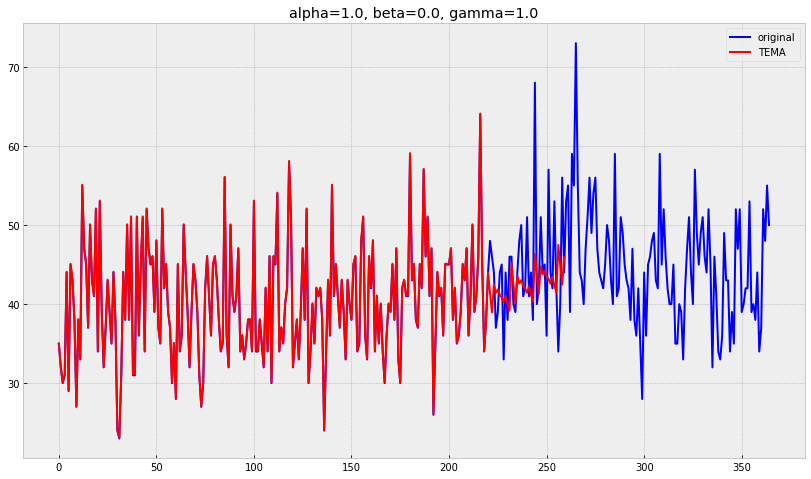

In [90]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

# Анализ временного ряда airlines_passengers

In [91]:
airlines = airlines_passengers["Count"]

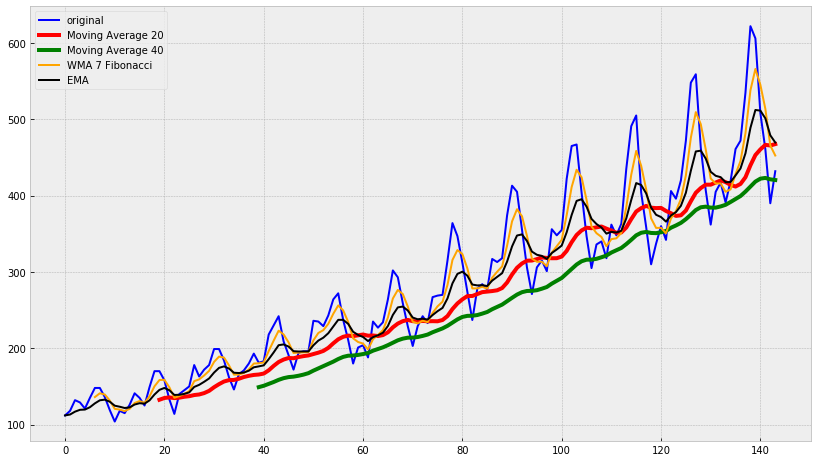

In [92]:
# Применим разные скользящие средние и визуализируем

ma20 = moving_average(airlines, 20)
ma40 = moving_average(airlines, 40)

wma_fib = weighted_moving_average(airlines, 7, [1,1,2,3,5,8,13])

ema = exponential_moving_average(airlines, 0.2)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines, color='blue',label='original')
    plt.plot(ma20, color='red', linewidth='4', label='Moving Average 20')
    plt.plot(ma40, color='green', linewidth='4', label='Moving Average 40')
    plt.plot(wma_fib, color='orange', linewidth='2', label='WMA 7 Fibonacci')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

### Подберем параметры для модели Хольта-Винтерса


In [93]:
len(airlines)

144

In [94]:
train, test, val = airlines[:87], airlines[87:100], airlines[100:]

In [95]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [96]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 515.7605016647443
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.72325871e+01,  3.41060513e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 8
   status: 0
  success: True
        x: array([1.        , 0.02159632, 1.        ])


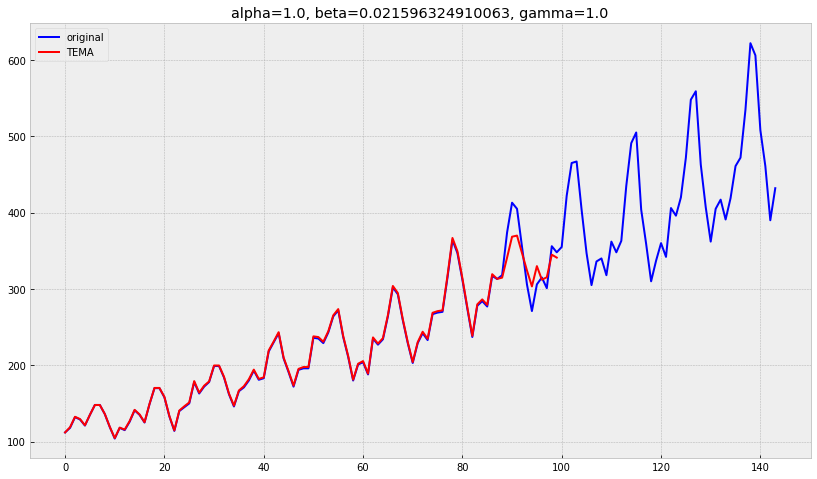

In [97]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=airlines, n_preds=len(test))

## Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

- Как можем видеть в обоих временных рядах при подборе параметров для модели Хольта-Винтерса, то получается довольно точно приболиженная модель для тренировочной выборки 
- При применении MA, WMA, EMA ожидаемо получаем сглаженные репрезентации временных рядов. Чем более простой метом, то более "сглаженный" результат получаем

